In [12]:
import pandas as pd
import numpy as np
from category_encoders.one_hot import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# data preprocessing
trainData = pd.read_csv('adult.data') # reads train data
trainData = trainData.applymap(lambda x: x.strip() if type(x) == str else x) # removes whitespaces from data
trainData = trainData.replace({'?': np.nan, '<=50K': 0, '>50K' : 1}) # replaces a bunch of values
trainData.dropna(axis = 0, how = 'any', inplace = True) # drops rows with NaN values
numTrainDataPoints = trainData.shape[0]
print("Total number of data points in training set: ", numTrainDataPoints)

testData = pd.read_csv('adult.test') # reads test data
testData = testData.applymap(lambda x: x.strip() if type(x) == str else x) # removes whitespaces from data
testData = testData.replace({'?': np.nan, '<=50K.': 0, '>50K.' : 1}) # replaces a bunch of values
testData.dropna(axis = 0, how = 'any', inplace = True) # drops rows with NaN values
numTestDataPoints = testData.shape[0]
print("Total number of data points in test set: ", numTestDataPoints)

# TODO: Add a check condition if the train and test dataframe have non-overlapping columns
allData = pd.concat([trainData, testData], axis = 0, ignore_index = True) # combines the train and test data to bring out the union

Total number of data points in training set:  30162
Total number of data points in test set:  15060


In [3]:
list_features = list(trainData.columns.values) # list down the attributes of data
listCatVar = trainData.select_dtypes(include='O').keys() # lists down all categorical variables
listContVar = list(set(list_features) - set(listCatVar)) # lists down all continuous variables
list_col = [] # list to store all encoded columms of the categorical data
for var in listCatVar: # appending columns to a list to form an one-hot encoded dataframe
    list_col.append(pd.get_dummies(allData[var], prefix = var))
allDataEncoded = pd.concat(list_col, axis = 1, ignore_index = False) # appending columns with in the list to form a dataframe
allDataEncoded = pd.concat([allDataEncoded, allData[listContVar]], axis = 1, ignore_index = False) # appending columns with continuous variables
print("Total number of features after one-hot encoding: ", allDataEncoded.shape[1])

Total number of features after one-hot encoding:  105


In [4]:
# Creating train, test datasets from encoded data
targetVarName = 'salary'
trainDataEncoded = allDataEncoded.loc[: numTrainDataPoints - 1] # extracting train data from allData
testDataEncoded = allDataEncoded.loc[numTrainDataPoints :] # extracting test data from allData
trainDataTarget = trainDataEncoded[targetVarName]; del trainDataEncoded[targetVarName] # extracting target values from train
testDataTarget = testDataEncoded[targetVarName]; del testDataEncoded[targetVarName] # extracting target values from test
print(testDataEncoded.shape, trainDataEncoded.shape)

(15060, 104) (30162, 104)


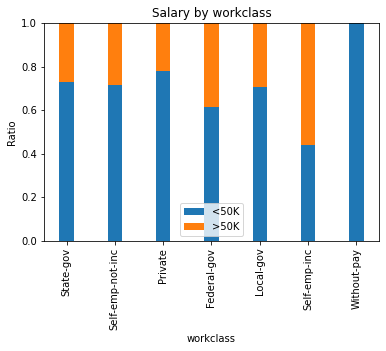

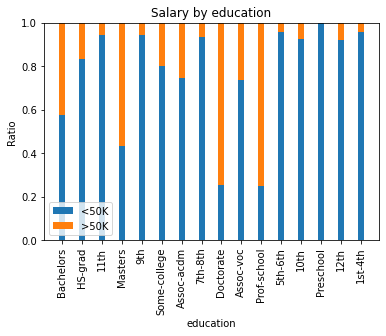

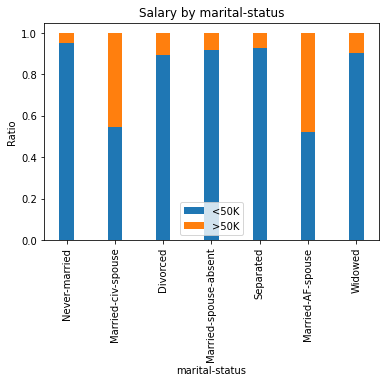

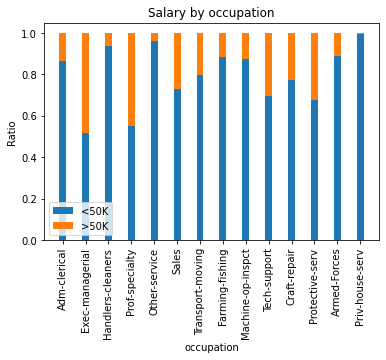

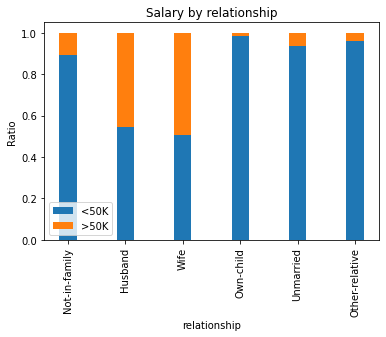

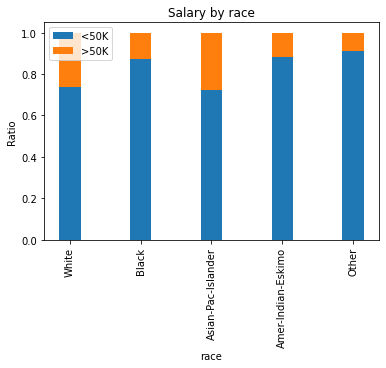

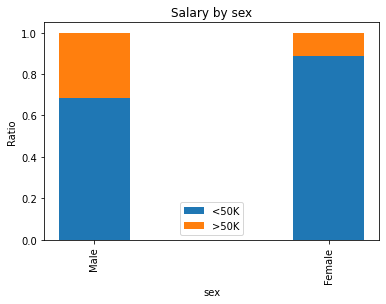

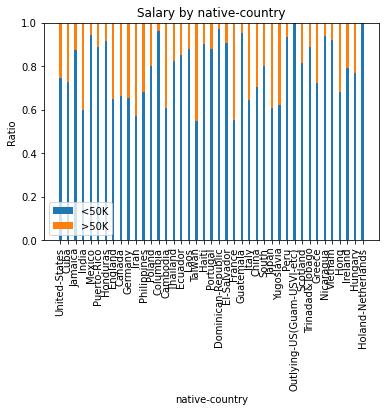

In [181]:
# Qualitative analysis of categorical variables
for cat in listCatVar:
    list_unique_cat = trainData[cat].unique()
    num_cat0 = []; num_cat1 = []
    for cat_unique in list_unique_cat:
        df = trainData.loc[trainData[cat] == cat_unique]
        df0 = df.loc[trainData['salary'] == 0]
        num_cat0.append(df0.shape[0] / df.shape[0]); num_cat1.append((df.shape[0] - df0.shape[0]) / df.shape[0])
    # Plot the salary bars
    width = 0.3
    fig, ax = plt.subplots()
    ax.bar(list_unique_cat, num_cat0, width, label = '<50K')
    ax.bar(list_unique_cat, num_cat1, width, bottom = num_cat0, label = '>50K')
    ax.set_ylabel('Ratio')
    ax.set_xlabel(cat, rotation = 0)
    ax.set_title('Salary by ' + cat); ax.legend()
    plt.xticks(rotation = 'vertical')
    plt.show()

# Add analysis for continuous variables and comments for categorical variables

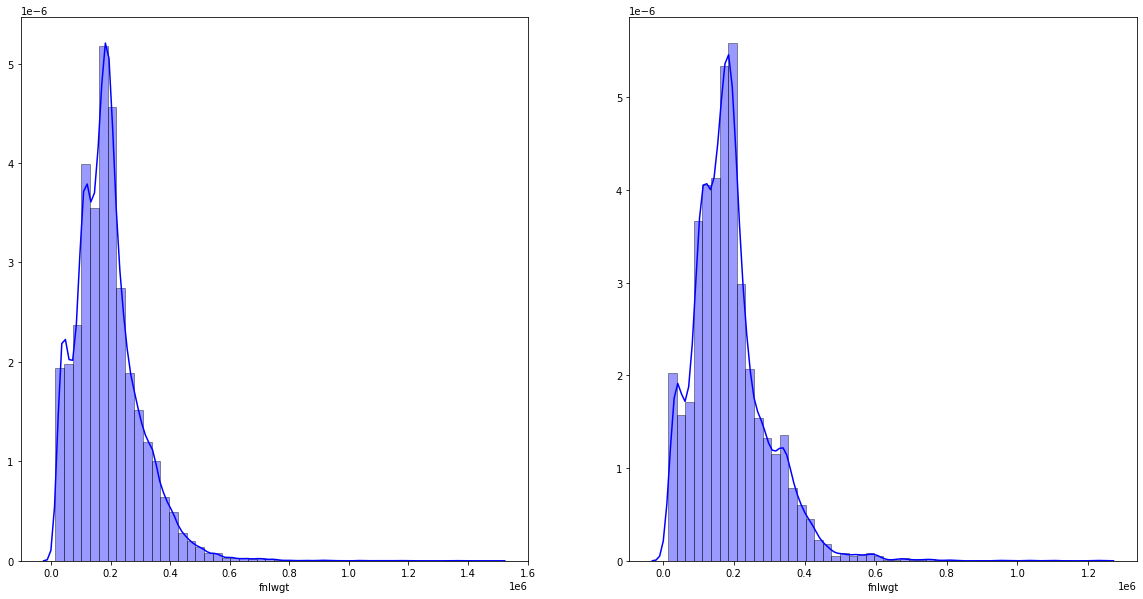

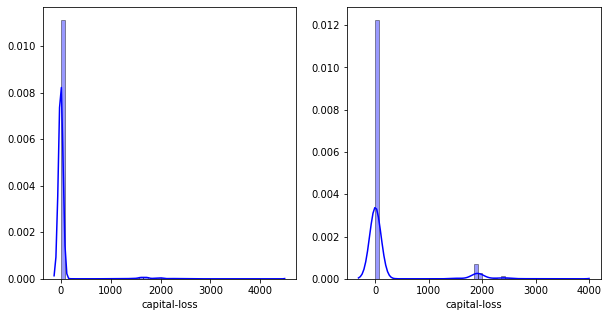

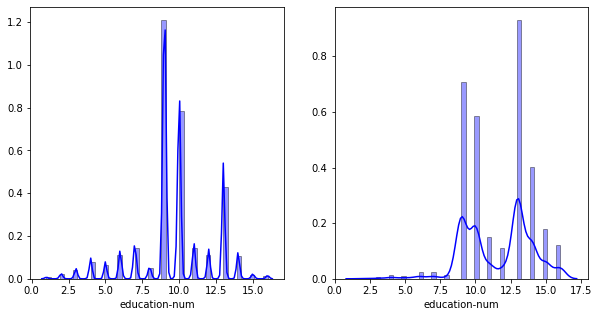

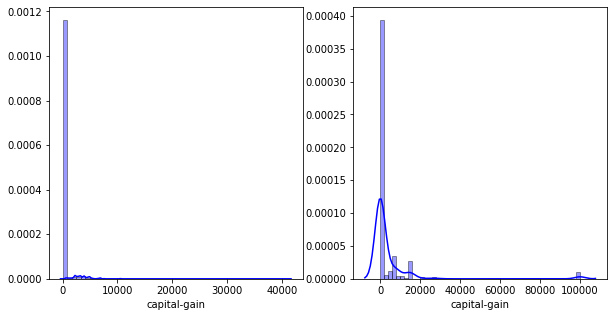

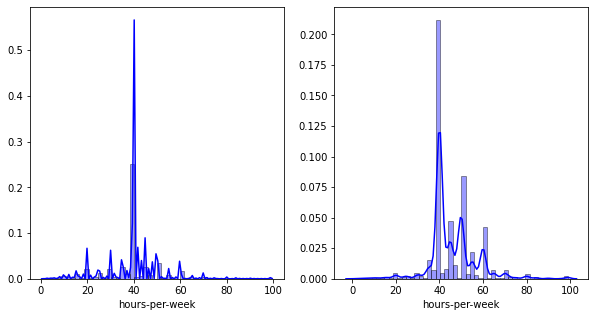

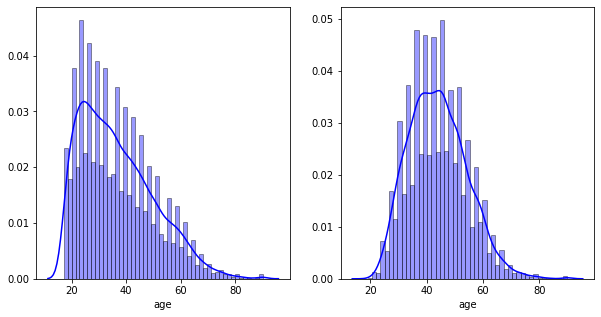

In [267]:
# Qualitative analysis of continuous variables
df0 = trainData.loc[trainData['salary'] == 0]
df1 = trainData.loc[trainData['salary'] == 1]
for cat in listContVar:
    if (cat == 'salary'):
        continue
    dfCat0 = df0[cat]; dfCat1 = df1[cat]
    fig, ax = plt.subplots(1,2)
    plt.rcParams["figure.figsize"] = (10,5)
    sns.distplot(df0[cat], hist = True, kde = True, color = 'blue', hist_kws={'edgecolor':'black'}, ax = ax[0])
    sns.distplot(df1[cat], hist = True, kde = True, color = 'blue', hist_kws={'edgecolor':'black'}, ax = ax[1])

In [17]:
scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}

# Classification using Naive-Bayes
gnb = GaussianNB()
# cv_scores_gnb = cross_val_score(gnb, trainDataEncoded, trainDataTarget, cv = 5)
cv_scores = cross_validate(estimator = gnb, X = trainDataEncoded, y = trainDataTarget, cv = 5, scoring = scoring)
list_scores = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1_score']
for s in list_scores:
    print(s, " = ", np.mean(cv_scores[s]))

clf_gnb = gnb.fit(trainDataEncoded, trainDataTarget)
y_pred = clf_gnb.predict(testDataEncoded)

# Performance on test data
accuracy = accuracy_score(testDataTarget, y_pred)
precision, recall, fscore, support = score(testDataTarget, y_pred)
print(accuracy, precision, recall, fscore)

test_accuracy  =  0.7884757232656288
test_precision  =  0.6603539518035098
test_recall  =  0.3095346999026837
test_f1_score  =  0.42145167974868497
0.7887118193891103 [0.80716647 0.64816934] [0.94586268 0.30621622] [0.87102789 0.41593245]


In [18]:
# Classification using Decision-Tree
dt = DecisionTreeClassifier(random_state = 0)
# cv_scores_dt = cross_val_score(dt, trainDataEncoded, trainDataTarget, cv = 5)
cv_scores = cross_validate(estimator = dt, X = trainDataEncoded, y = trainDataTarget, cv = 5, scoring = scoring)

list_scores = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1_score']
for s in list_scores:
    print(s, " = ", np.mean(cv_scores[s]))

clf_dt = dt.fit(trainDataEncoded, trainDataTarget)
y_pred = clf_dt.predict(testDataEncoded)

# Performance on test data
accuracy = accuracy_score(testDataTarget, y_pred)
precision, recall, fscore, support = score(testDataTarget, y_pred)
print(accuracy, precision, recall, fscore)

test_accuracy  =  0.8089985022693489
test_precision  =  0.6135981550059351
test_recall  =  0.6287982002233753
test_f1_score  =  0.6210556684106758
0.8049136786188579 [0.8733156  0.60079365] [0.86716549 0.61378378] [0.87022968 0.60721925]


In [19]:
# Classification using Logistic-Regression
lr = LogisticRegression(random_state = 1)
# cv_scores_lr = cross_val_score(lr, trainDataEncoded, trainDataTarget, cv = 5)
cv_scores = cross_validate(estimator = gnb, X = trainDataEncoded, y = trainDataTarget, cv = 5, scoring = scoring)

list_scores = ['test_accuracy', 'test_precision', 'test_recall', 'test_f1_score']
for s in list_scores:
    print(s, " = ", np.mean(cv_scores[s]))

clf_lr = lr.fit(trainDataEncoded, trainDataTarget)
y_pred = clf_lr.predict(testDataEncoded)

# Performance on test data
accuracy = accuracy_score(testDataTarget, y_pred)
precision, recall, fscore, support = score(testDataTarget, y_pred)
print(accuracy, precision, recall, fscore)

test_accuracy  =  0.7884757232656288
test_precision  =  0.6603539518035098
test_recall  =  0.3095346999026837
test_f1_score  =  0.42145167974868497
0.7926958831341302 [0.80166984 0.70554765] [0.96355634 0.26810811] [0.87518989 0.38856248]
